In [ ]:
import os
import random
from io import BytesIO

import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as models
import torchvision.models.vgg as vgg

from diffusers import StableDiffusionInpaintPipeline
from huggingface_hub import hf_hub_download

from read_dataset import read_dataset
from train import train
from segmentation import segementation,Segmentation_model
from diffusion import *
from llm import *
from preprop import *

# Jupyter Notebook 내에서 matplotlib 출력 설정
%matplotlib inline

/home/shlee/Desktop/outta_proj/cloth_change/cloth_change_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
seed = 32
model = Segmentation_model(num_classes=7,encoder='resnet34',pre_weight = 'imagenet')

epoch = 80
learning_rate = 1e-3

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# **1. Train**

In [3]:
file_path = './dataset/G2_train.h5'
data_len = 10000
img_list, gt_list = read_dataset(file_path, data_len)

In [ ]:
train(img_list, gt_list, model, epoch, learning_rate,criterion,optimizer,64)

Epoch [1/80] Train Loss : 0.24619340641844656
Val Loss: 0.0932, Val_mAP:0.9576, Val_mIOU : 0.8010
Epoch [2/80] Train Loss : 0.621147979459455
Val Loss: 0.1748, Val_mAP:0.8083, Val_mIOU : 0.5981
Epoch [3/80] Train Loss : 0.1506694451455147
Val Loss: 0.1306, Val_mAP:0.8971, Val_mIOU : 0.7099
Epoch [4/80] Train Loss : 0.12275107738471801
Val Loss: 0.1138, Val_mAP:0.9227, Val_mIOU : 0.7480
Epoch [5/80] Train Loss : 0.1098413880794279
Val Loss: 0.1130, Val_mAP:0.9291, Val_mIOU : 0.7518
Epoch [6/80] Train Loss : 0.10190514047299662
Val Loss: 0.0987, Val_mAP:0.9394, Val_mIOU : 0.7764
Epoch [7/80] Train Loss : 0.09511261332419611
Val Loss: 0.0881, Val_mAP:0.9474, Val_mIOU : 0.7884
Epoch [8/80] Train Loss : 0.08937539530377234
Val Loss: 0.0834, Val_mAP:0.9541, Val_mIOU : 0.7996
Epoch [9/80] Train Loss : 0.08650531687082783
Val Loss: 0.0829, Val_mAP:0.9572, Val_mIOU : 0.7933
Epoch [10/80] Train Loss : 0.08095334561601762
Val Loss: 0.0733, Val_mAP:0.9620, Val_mIOU : 0.8160
Epoch [11/80] Train Los

# **2. Get Segmentation Mask**

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = 'model_save/Resnet34_unet.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)


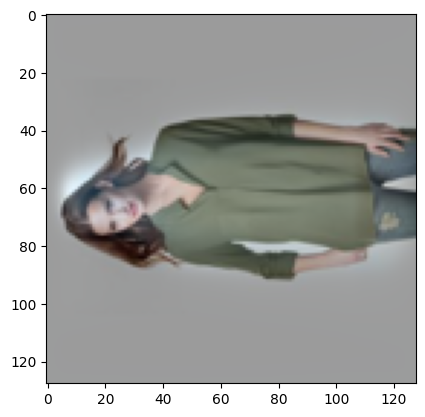

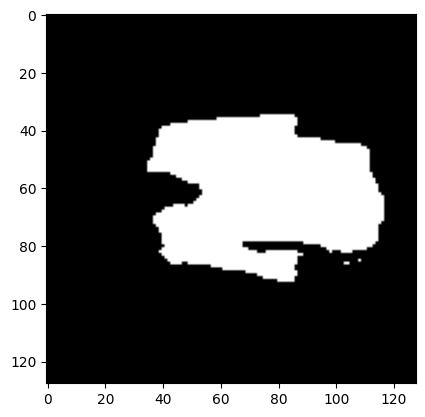

In [6]:
# ResNet34UNet
image = np.load('./test_image3.npy')
plt.imshow(image)
plt.show()

# 결과 시각화
model.eval()
vis_output_model = segementation(image, model)
plt.imshow(vis_output_model)
plt.show()

## **(3) LLM to Diffusion**

### **1) LLM**

In [ ]:
prompt = "Give more Detail of the below cloth described sentence. The cute and small tiger is in center of the blue T-shirt."
negative_prompt = "ugly"

text = LLM(prompt)
text.text

"The base garment is a classic, crew-necked, short-sleeved T-shirt in a vibrant, medium-toned blue.  The fabric is a lightweight cotton jersey, chosen for its breathability and comfortable drape.  Centrally positioned on the chest is a meticulously rendered illustration of a small, endearing tiger cub. The tiger is depicted in a playful pose, perhaps sitting or playfully pouncing, rendered in shades of burnt orange, deep amber, black, and white for contrast against the blue. The lines are clean and slightly cartoonish, avoiding photorealism in favor of a more charming, childlike aesthetic.  The tiger's expression is sweet and innocent, possibly with wide, friendly eyes.  The overall design maintains a clean, uncluttered look, ensuring the focus remains on the adorable tiger, which is slightly smaller than a typical adult hand, to emphasize its cuteness.  The colors are all relatively saturated and bright, creating an overall cheerful and positive vibe.  There's no additional embellishm

### **2) Mask Inpainting by Stable Diffusion**

In [ ]:
# 사전학습된 StableDiffusionInpaintPipeline 불러오고, GPU로 로드
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    ).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 36.32it/s]


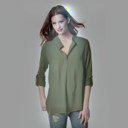

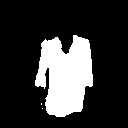

In [9]:
image_source_pil, image_mask_pil = preprop_for_diffusion(image, vis_output_model)

In [11]:
generated_image = generate_image(image=image_source_pil, mask=image_mask_pil, prompt=text.text, negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed, device=device)
resizd_generated_image = generated_image.resize((512,512))
resized_original_image = image_source_pil.resize((512,512))

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["pose , perhaps sitting or playfully pouncing , rendered in shades of burnt orange , deep amber , black , and white for contrast against the blue . the lines are clean and slightly cartoonish , avoiding photorealism in favor of a more charming , childlike aesthetic . the tiger 's expression is sweet and innocent , possibly with wide , friendly eyes . the overall design maintains a clean , uncluttered look , ensuring the focus remains on the adorable tiger , which is slightly smaller than a typical adult hand , to emphasize its cuteness . the colors are all relatively saturated and bright , creating an overall cheerful and positive vibe . there 's no additional embellishment beyond the tiger artwork itself ."]
100%|██████████| 50/50 [00:05<00:00,  9.37it/s]


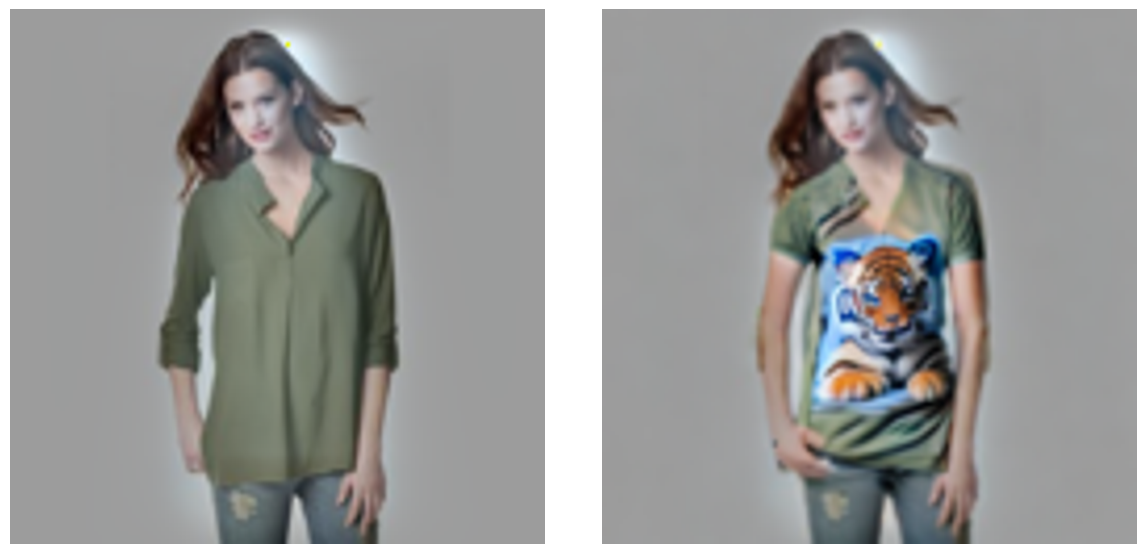

In [13]:
fig,axs=plt.subplots(1,2 ,figsize = (12,6))
plt.tight_layout()
axs[0].imshow(resized_original_image)
axs[0].axis('off')
axs[1].imshow(resizd_generated_image)
axs[1].axis('off')

plt.show()